In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from pol.utils.validation.scene_saver import load_scenes, count_h5_keys

In [2]:
prob = 'small_test'
all_methods = ['pol_mlp', 'pd']
cmap = plt.cm.get_cmap('hsv', len(all_methods)+1)
colors = {all_methods[i]: cmap(i) for i in range(len(all_methods))}
scene_path_fmt = '../../tests/spring_equilibrium/scenes/{}/{}'
max_num_iter = 2000
prox_val_step = 2000
theta_range = range(0, 1)
hist_max_rel = 0.0

In [3]:
import ipywidgets as widgets
method_select_widget = widgets.SelectMultiple(
    options=all_methods,
    value=all_methods,
    description='Methods',
    disabled=False
)
fig_path = Path('figs')
fig_path.mkdir(exist_ok=True)

In [4]:
def load_exp_scene(prob, method):
    if method.startswith('pd'):
        scene = load_scenes((scene_path_fmt + '/result.h5').format(prob, method))[-1]
    else:
        scene = load_scenes((scene_path_fmt + '/step-{:05}.h5').format(prob, method, prox_val_step))[-1]
    return scene

def plot_convergence(theta_idx, ax_traj, ax_hist, methods):
    def plot_traj(Ls, name, color):
        # Ls is an array of shape B ndarray's.
        L_stacked = np.stack(Ls, 0) # TxB
        is_finite = np.abs(L_stacked).max() < 1e3
        if not is_finite:
            print('{} has exploding loss!'.format(name))
            return
        traj_mean = L_stacked.mean(-1)
        traj_std = L_stacked.std(-1)
        ax_traj.plot(traj_mean, color=color, label=name)
        ax_traj.fill_between(range(traj_mean.shape[0]), traj_mean-traj_std, traj_mean+traj_std, alpha=0.5, color=color)

    loss_stats = []
    for method_idx, method in enumerate(methods):
        exp_name = '{}/{}'.format(prob, method)

        scene = load_exp_scene(prob, method)

        if method_idx == 0:
            theta = scene['info']['thetas'][theta_idx, :]

        Ls = []
        num_iter = min(count_h5_keys(scene, 'itr'), max_num_iter+1)
        for k in range(num_iter):
            Ls.append(scene['itr_{}'.format(k)]['loss'][theta_idx, :]) # B
        plot_traj(Ls, exp_name, colors[method])
        
        loss_stats.append((Ls[-1], 
                           exp_name, colors[method]))
    
    
    # Next plot histograms.
    loss_lb = 1e100
    loss_rb = -1e100
    for L, _, _ in loss_stats:
        loss_lb = min(loss_lb, L.min())
        loss_rb = max(loss_rb, L.max())
    if hist_max_rel > 0:
        loss_rb = min(loss_rb, loss_lb * hist_max_rel)
    hist_bins = np.linspace(loss_lb, loss_rb, 50)
    ax_hist.hist([s[0] for s in loss_stats], hist_bins, 
                 color=[s[2] for s in loss_stats], 
                 label=[s[1] for s in loss_stats])

    ax_traj.legend()
    ax_traj.set_ylabel('objective')
    ax_traj.set_xlabel('number of iterations')
    ax_hist.legend()
    ax_hist.set_title('theta={}'.format(theta))
    ax_hist.set_xlabel('objective')
    ax_hist.set_ylabel('frequency')

def vis1():
    fig_size = 5
    fig, axes = plt.subplots(2, len(theta_range), squeeze=False)
    fig.set_figheight(fig_size)
    fig.set_figwidth(fig_size*len(theta_range))
    for t, theta in enumerate(theta_range):
        plot_convergence(theta, axes[0, t], axes[1, t], method_select_widget.value)
    plt.tight_layout()
    fig.savefig('figs/{}_loss.png'.format(prob))
    
def plot_string(ax, theta_idx, sol_id, method):
    ax.set_aspect('equal')
    def plot(Xs, name, color):
        for t in range(len(Xs)):
            alpha = 1.0 if len(Xs) == 1 else 0.1+t/len(Xs)*0.9
            ax.plot(Xs[t][:, 0], Xs[t][:, 1], '--', marker='o', color=color, alpha=alpha)

    exp_name = '{}/{}'.format(prob, method)

    scene = load_exp_scene(prob, method)
    # print(scene.keys())
    Xs = []
    last_itr = count_h5_keys(scene, 'itr') - 1
    # print(last_itr)
    k_range = [0, 5, 10, 15, 20] # [last_itr] 
    #for k in range(num_iter):
    for k in k_range:
        Xs.append(scene['itr_{}'.format(k)]['positions'][theta_idx, sol_id, :, :]) # (F+2)x2
    plot(Xs, exp_name, colors[method])
    
def vis2():
    theta_idx = 0
    fig_size = 4
    num_sol = 10
    methods = method_select_widget.value
    fig, axes = plt.subplots(len(methods), num_sol, squeeze=False)
    fig.set_figheight(fig_size*len(methods))
    fig.set_figwidth(fig_size*num_sol)
    for i, method in enumerate(methods):
        for j in range(num_sol):
            plot_string(axes[i, j], theta_idx, j, method)
    fig.savefig('figs/{}_2d_vis.png'.format(prob))

In [5]:
display(method_select_widget)

SelectMultiple(description='Methods', index=(0, 1), options=('pol_mlp', 'pd'), value=('pol_mlp', 'pd'))

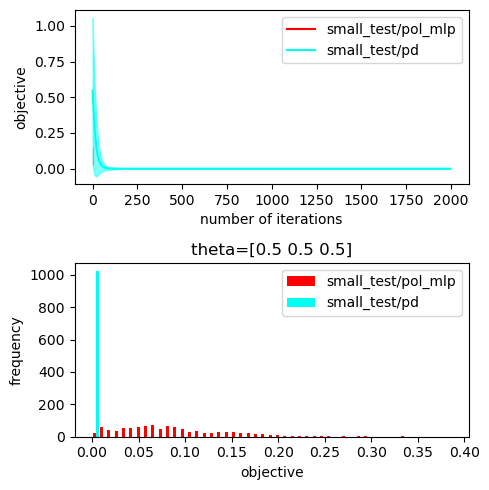

In [6]:
vis1()

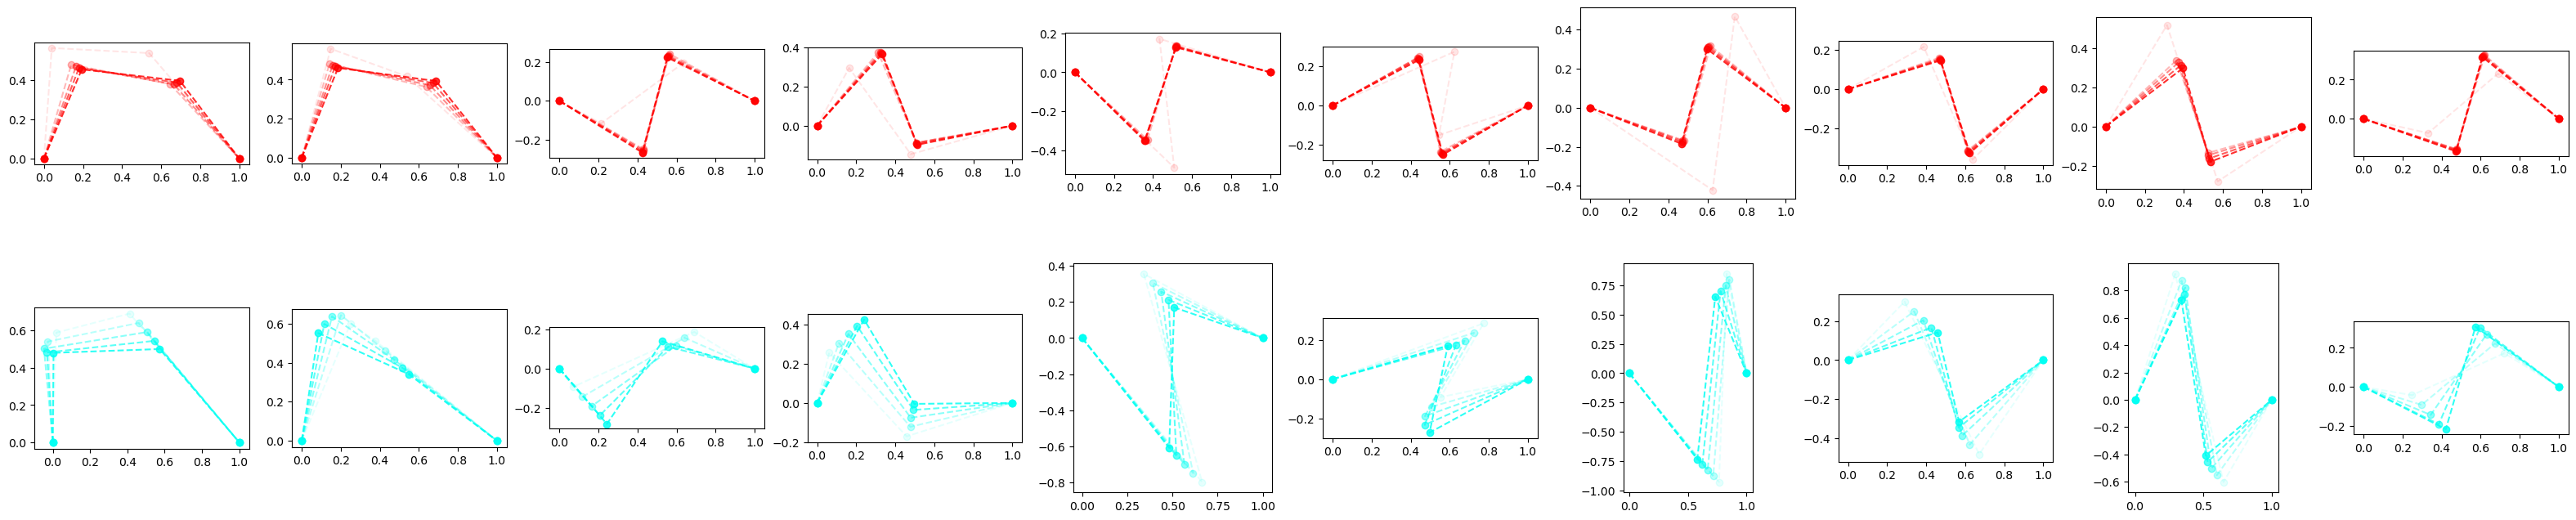

In [7]:
# We next visualize the spring in iterations [0, 5, 10, 15, 20] for each method. More opaque colors indicate later iterations.
# We should see that POL converges much faster than PD to an equilibrium state (spring segments have the same lengths).
vis2()